In [3]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [4]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [5]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [78]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [44]:
import regions
from astropy.io import fits

In [45]:
cd /orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/

/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N


In [46]:
reg = regions.Regions.read('/orange/adamginsburg/jwst/brick/regions/detectoroverlap_problemzone.reg')

In [47]:
import glob

In [48]:
files = glob.glob("*i2d.fits")

In [56]:
import warnings

In [57]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    masks = [reg[0].to_pixel(wcs.WCS(fits.getheader(fn, ext=1))).to_mask() for fn in files]
    shapes = [fits.getdata(fn, ext=1).shape for fn in files]
    cutouts = [mask.cutout(fits.getdata(fn, ext=1)) for mask,fn in zip(masks, files)]

In [58]:
len(cutouts)

193

In [59]:
import numpy as np

In [60]:
len([c for c in cutouts if np.any(c)])

23

In [62]:
tbl = Table.read('/orange/adamginsburg/jwst/brick/catalogs/jw02221-o001_t001_nircam_clear-f212n_cat.ecsv')
crds = tbl['sky_centroid']
crds_in = crds[reg[0].contains(crds, wcs=wcs.WCS(fits.getheader(files[0], ext=1)))]

Set DATE-AVG to '2022-08-28T02:01:42.926' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.687419 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526711813.954 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(slice(2154, 2425, None), slice(5665, 5917, None))
(slice(1692, 1961, None), slice(12, 263, None))
(slice(1728, 1994, None), slice(1918, 2058, None))
(slice(2045, 2064, None), slice(1813, 2058, None))
(slice(2003, 2064, None), slice(1879, 2058, None))
(slice(1998, 2065, None), slice(64, 315, None))
(slice(1928, 2065, None), slice(30, 280, None))
(slice(0, 125, None), slice(1829, 2058, None))
(slice(2036, 2065, None), slice(4, 255, None))
(slice(0, 82, None), slice(1897, 2058, None))
(slice(1701, 1967, None), slice(1817, 2058, None))
(slice(1653, 1922, None), slice(72, 323, None))
(slice(0, 193, None), slice(1872, 2058, None))
(slice(0, 75, None), slice(59, 314, None))
(slice(0, 46, None), slice(0, 211, None))
(slice(0, 153, None), slice(1932, 2058, None))
(slice(1659, 1925, None), slice(1883, 2058, None))
(slice(1583, 1852, None), slice(38, 289, None))
(slice(1625, 1894, None), slice(0, 222, None))
(slice(0, 4, None), slice(24, 279, None))
(slice(1969, 2065, None), slice(0, 214, None))

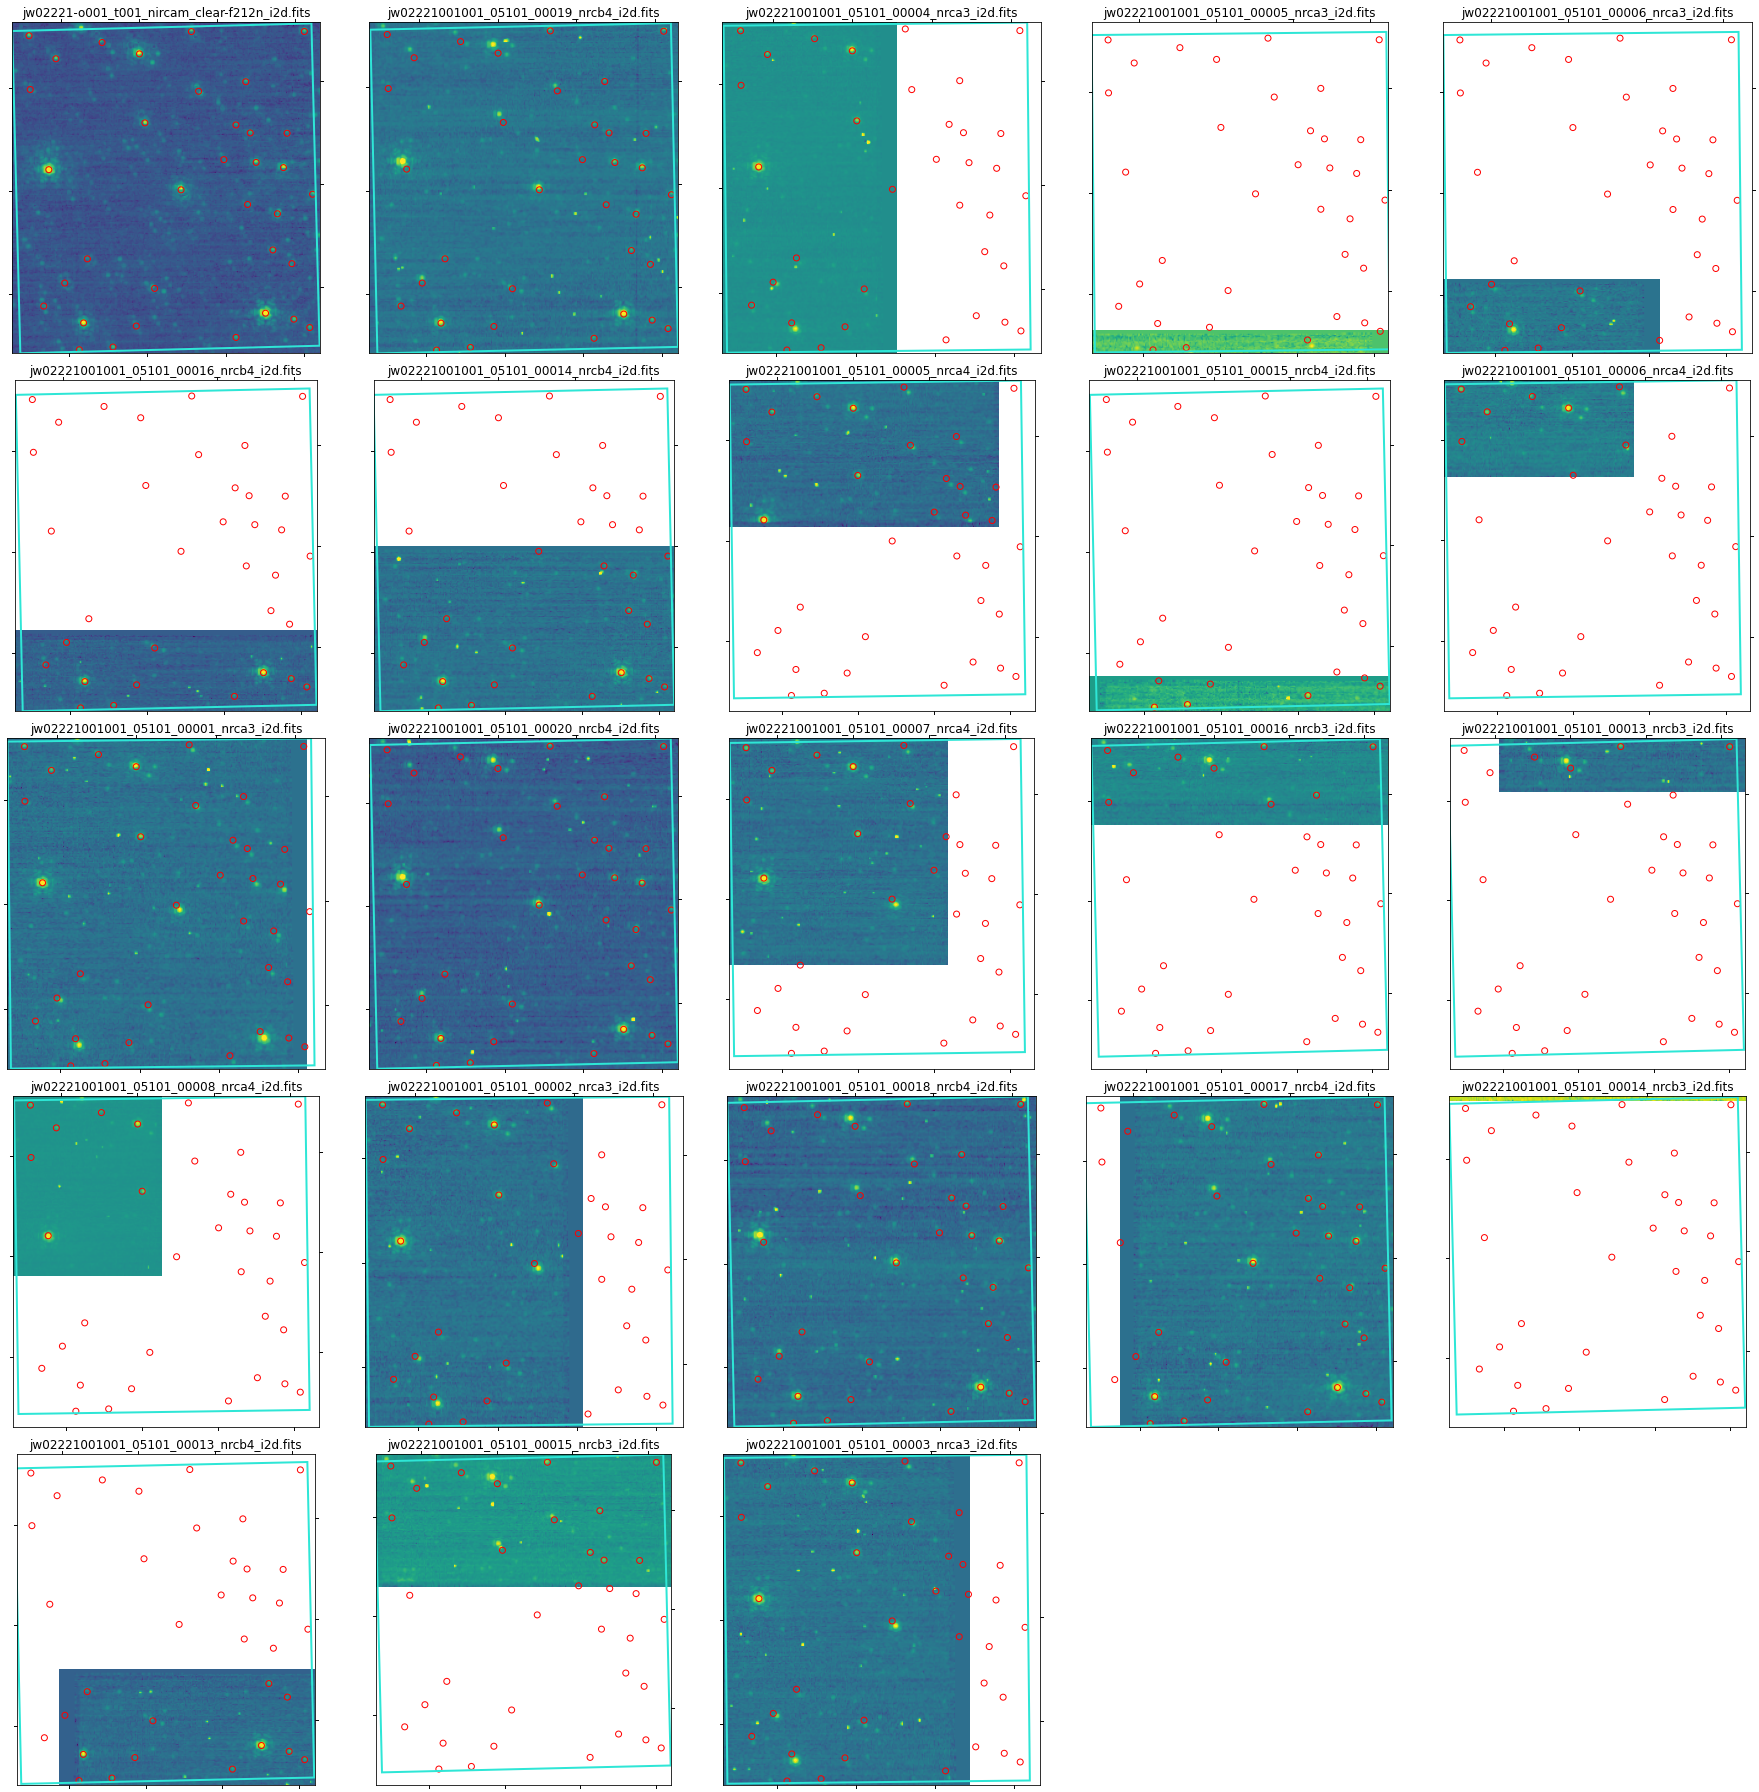

In [88]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    for ii, (co, mask, shape, fn) in enumerate([(co, mask, shape, fn) for co, mask, shape, fn in zip(cutouts, masks, shapes, files) if np.any(co)]):
        slcs,_ = mask.get_overlap_slices(fits.getdata(fn, ext=1).shape)
        #co = mask.cutout(fits.getdata(fn, ext=1))
        co = fits.getdata(fn, ext=1)[slcs]
        #print(slcs)
        ax = pl.subplot(5,5,ii+1, projection=wcs.WCS(fits.getheader(fn, ext=1))[slcs])
        ax.set_title(fn)
        ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
        ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
        rr = reg[0].to_pixel(ax.wcs)
        rr.plot()
        ax.set_xticks([])
        ax.set_yticks([])
    pl.tight_layout()

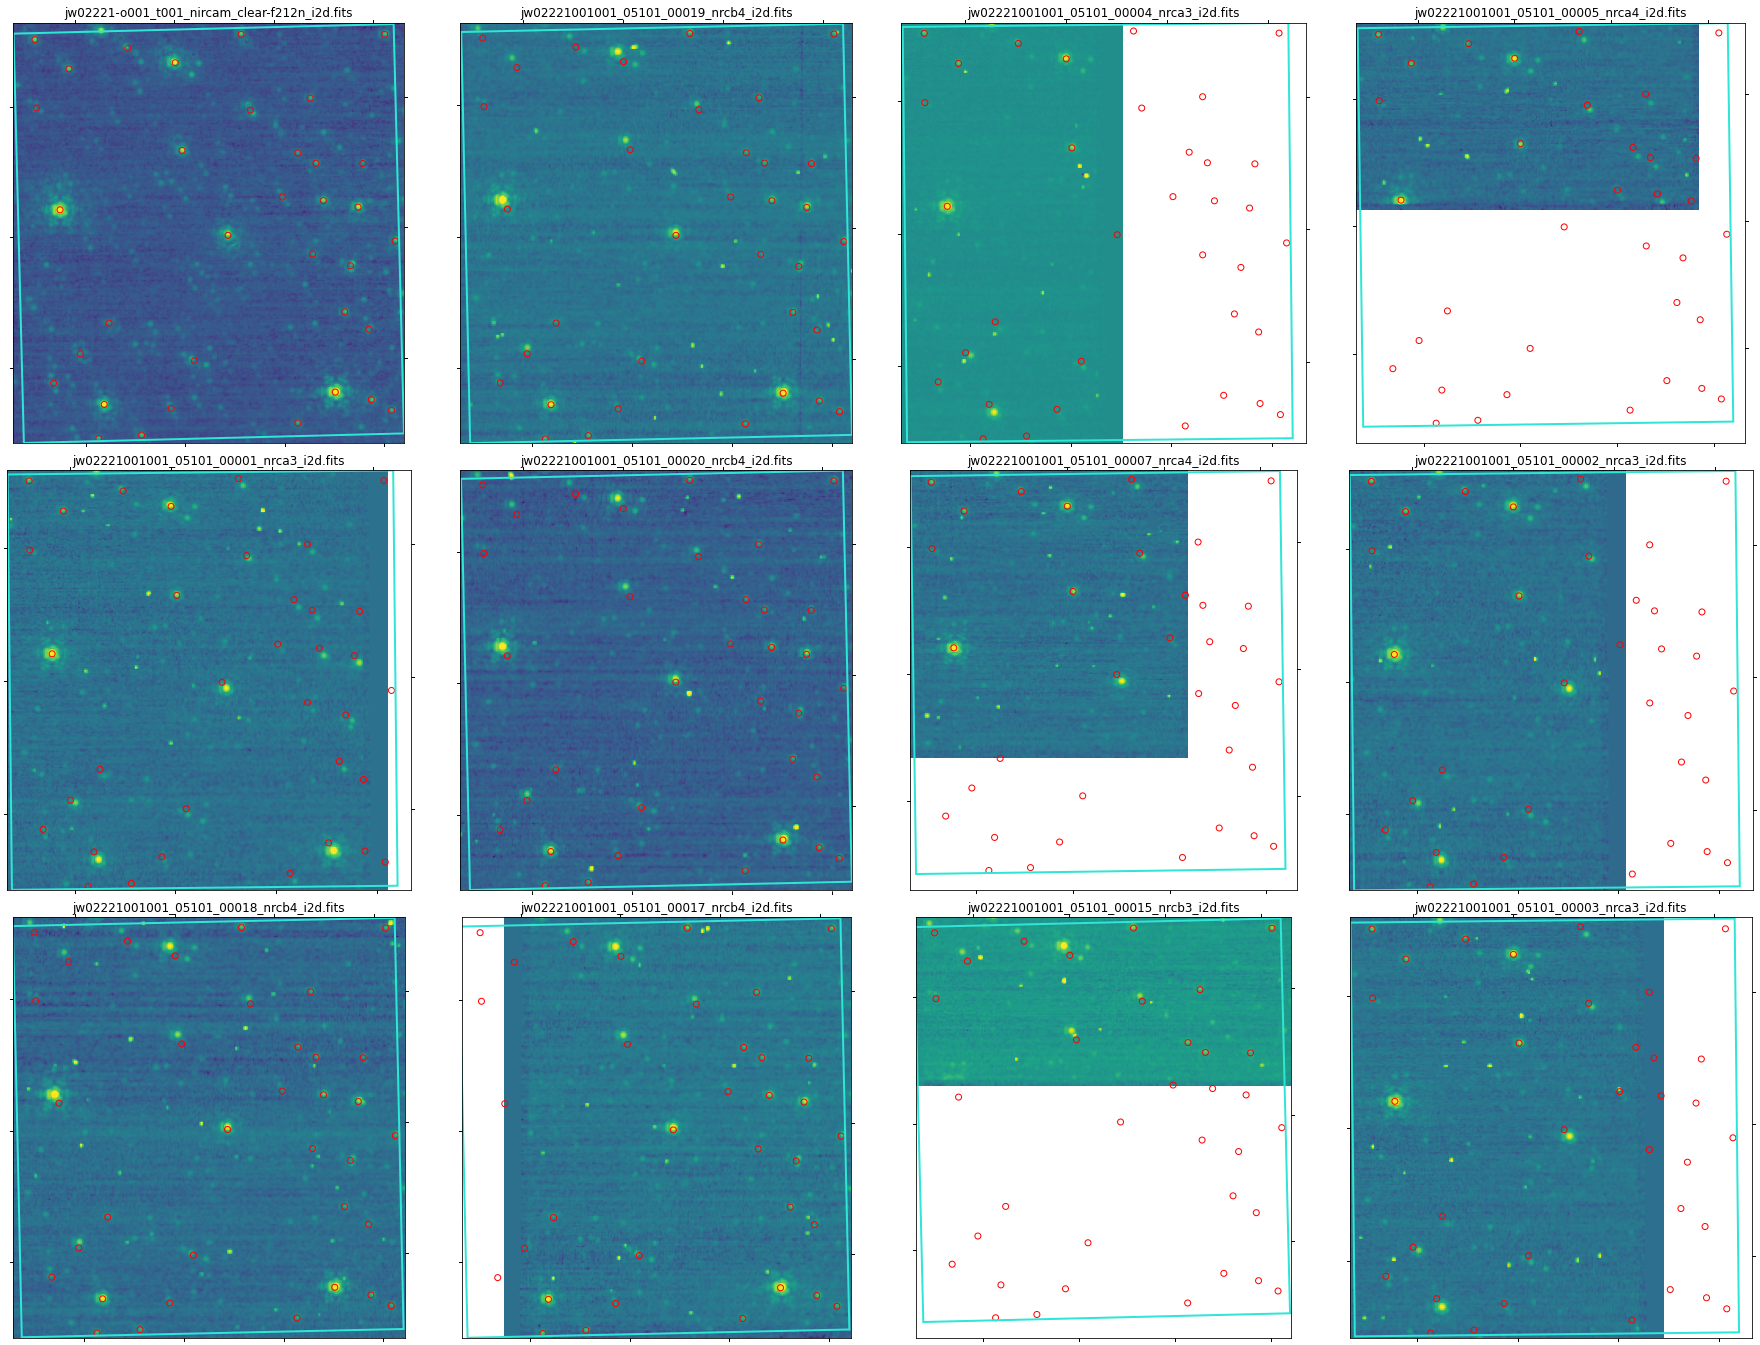

In [96]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    for ii, (co, mask, shape, fn) in enumerate([(co, mask, shape, fn) for co, mask, shape, fn in zip(cutouts, masks, shapes, files) if np.any(co) and (co > 0).sum() > 20000]):
        slcs,_ = mask.get_overlap_slices(fits.getdata(fn, ext=1).shape)
        #co = mask.cutout(fits.getdata(fn, ext=1))
        co = fits.getdata(fn, ext=1)[slcs]
        #print(slcs)
        ax = pl.subplot(4,4,ii+1, projection=wcs.WCS(fits.getheader(fn, ext=1))[slcs])
        ax.set_title(fn)
        ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
        ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
        rr = reg[0].to_pixel(ax.wcs)
        rr.plot()
        ax.set_xticks([])
        ax.set_yticks([])
    pl.tight_layout()

In [100]:
ww = wcs.WCS(fits.getheader(fn, ext=1))
ww

Set DATE-AVG to '2022-08-28T01:40:20.178' from MJD-AVG.
Set DATE-END to '2022-08-28T01:40:47.020' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.689454 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526735756.458 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.5256313893235  -28.7210628894108  
CRPIX : 1023.04537911023  1032.452278952191  
PC1_1 PC1_2  : -0.01049446885842607  0.9999449315454224  
PC2_1 PC2_2  : 0.9999449315454224  0.01049446885842607  
CDELT : 8.71272664075585e-06  8.71272664075585e-06  
NAXIS : 2058  2064

/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221-o001_t001_nircam_clear-f212n_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00019_nrcb4_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00004_nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00014_nrcb4_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00001_nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00020_nrcb4_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00007_nrca4_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00002_nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00018_nrcb4_i2d.fits
/orange/adamginsburg/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00017_nrcb4_i2d.fits
/orange/adamginsburg/jwst

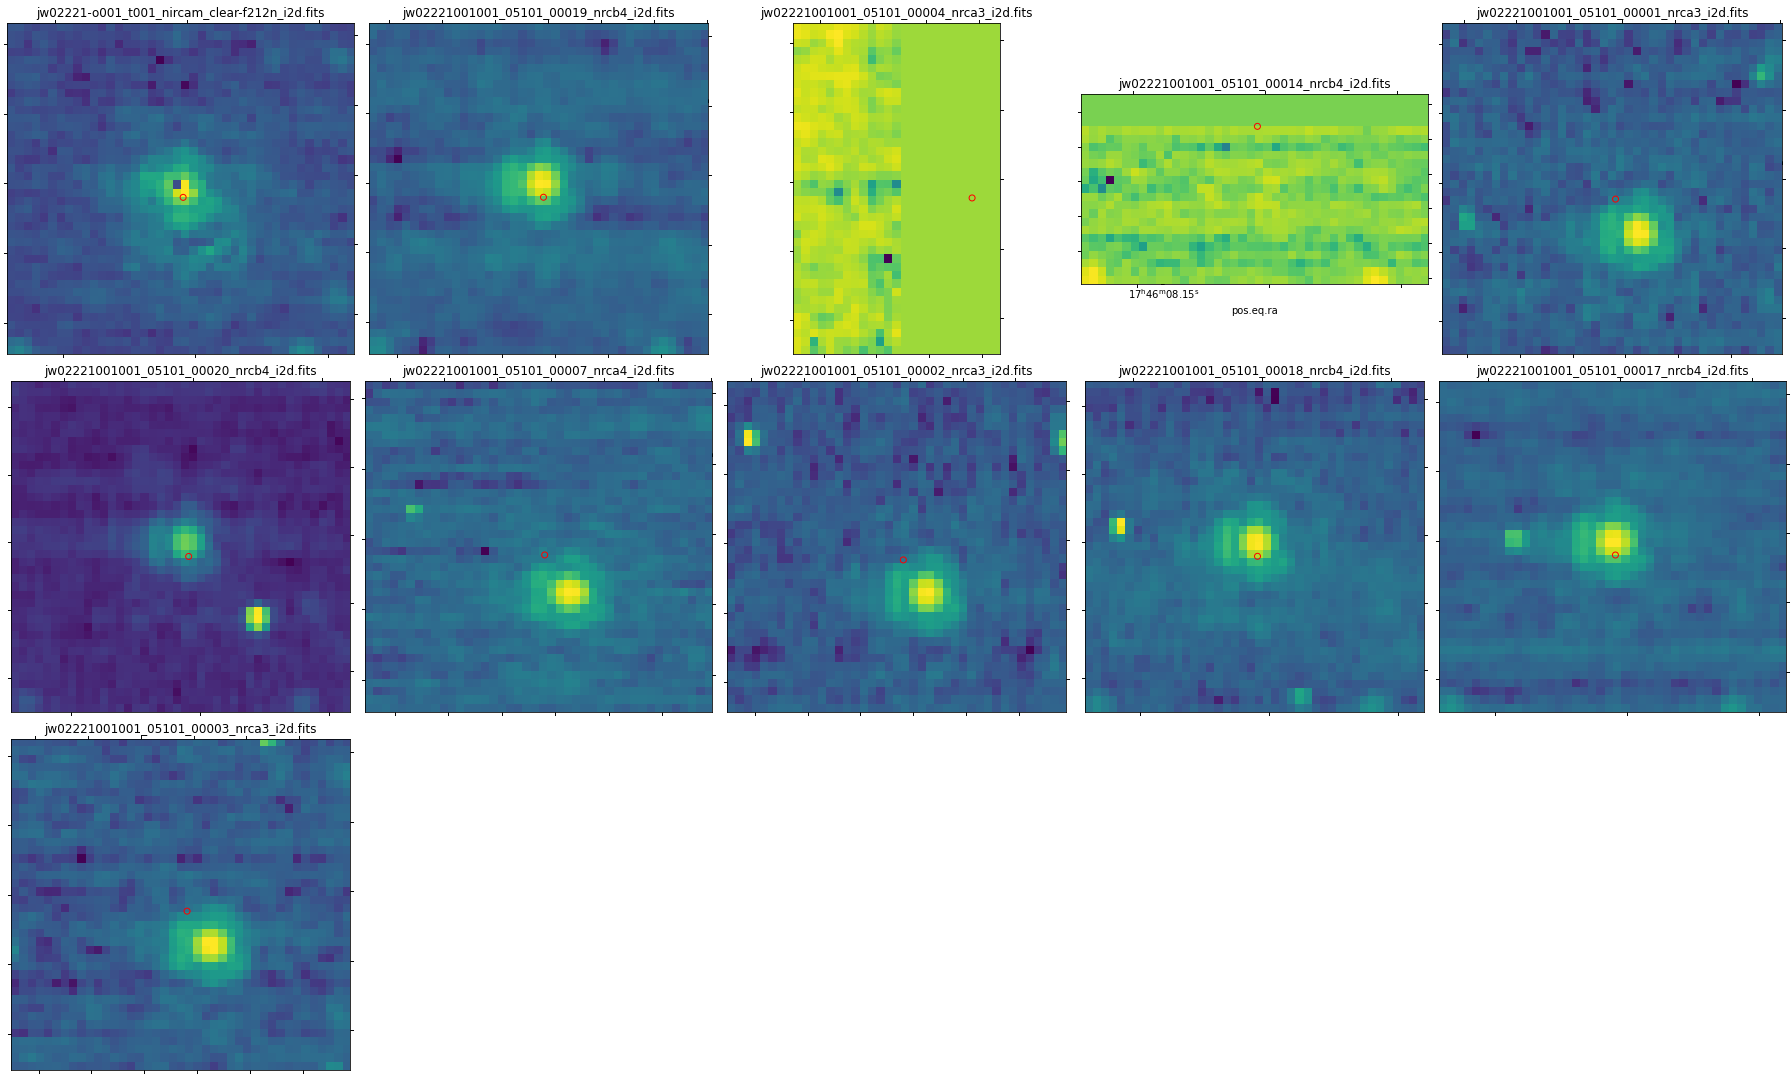

In [109]:
starreg = regions.Regions.read('/orange/adamginsburg/jwst/brick/regions/overlap_refstar.reg')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    ii = 1
    for fn in files:
        hdr = fits.getheader(fn, ext=1)
        ww = wcs.WCS(hdr)
        if ww.footprint_contains(starreg[0].center):
            preg = starreg[0].to_pixel(ww)
            mask = preg.to_mask()
            data = fits.getdata(fn, ext=1)
            slcs,_ = mask.get_overlap_slices(data.shape)
            co = data[slcs]
            if not np.any(co) or slcs is None:
                continue
            #print(slcs)
            ax = pl.subplot(5,5,ii, projection=ww[slcs])
            ii+=1
            ax.set_title(fn)
            ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
            crds_in2 = crds[starreg[0].contains(crds, wcs=ww)]
            ax.scatter(crds_in2.ra, crds_in2.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
            ax.set_xticks([])
            ax.set_yticks([])
            print(f'{os.getcwd()}/{fn}')
    pl.tight_layout()

await app.openFile("/jwst/brick/mastDownload/JWST/F212N/jw02221-o001_t001_nircam_clear-f212n_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00019_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00004_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00014_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00001_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00020_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00007_nrca4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00002_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00018_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00017_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00003_nrca3_i2d.fits")